In [43]:
import numpy as np
import numba as nb
import scipy.sparse as sps
import scipy.sparse.linalg as spslinalg
from scipy.fftpack import fft2, ifft2, fftshift, fftfreq
import sys
#import pyvie as pv

# Plotting Utilities
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns

# Add the path for the modules to the search path
sys.path.append(r'../Common/')
sys.path.append(r'../Functions/')

from asymmetric_euler_particle_solve_conserving import asym_euler_particle_heating_solver as asym_euler_particle_heating_solver_conserving
from asymmetric_euler_particle_solve_original import asym_euler_particle_heating_solver as asym_euler_particle_heating_solver_original

# Use LaTeX in the plots
# plt.rc('text', usetex=True)

from field_advance import *
from particle_funcs import *
from precompile import *
from plotting_funcs import *
from error import *

# Profiling 
import time
import cProfile
import pstats
import io
import os

In [44]:
print("\n=====================================================================\n")

# How many threads are being used?
print("get_num_threads():", nb.get_num_threads(), "\n")

# Number of CPU cores on the system
print("NUMBA_DEFAULT_NUM_THREADS:", nb.config.NUMBA_DEFAULT_NUM_THREADS, "\n")

# Number of threads n must be less than or equal
# to NUMBA_NUM_THREADS the total number of threads 
# that are launched (defaults to # of physical cores)
print("NUMBA_NUM_THREADS:", nb.config.NUMBA_NUM_THREADS, "\n")

# Use the OpenMP thread backend
# This can be done by setting the
# environment variable NUMBA_THREADING_LAYER="omp"

# Check that the backend is set by the environment variable
print("THREADING_LAYER:", nb.config.THREADING_LAYER, "\n")




get_num_threads(): 12 

NUMBA_DEFAULT_NUM_THREADS: 12 

NUMBA_NUM_THREADS: 12 

THREADING_LAYER: default 



In [45]:
def get_max_value(*values):
    return max(values)

In [46]:
# Speed of light
c = 2.99792458e08  # Units of m/s

# Permittivity and permeability of free space
epsilon_0 = 8.854187817e-12 # Units of L^{-3} M^{-1} T^{4} A^{2}
mu_0 = 1.25663706e-06 # Units of MLT^{-2} A^{-2}

# Boltzmann constant in SI units
k_B = 1.38064852e-23 # Units of L^{2} M T^{-2} K^{-1} (energy units)

# Particle species mass parameters
ion_electron_mass_ratio = 10000.0

electron_charge_mass_ratio = -175882008800.0 # Units of C/kg
ion_charge_mass_ratio = -electron_charge_mass_ratio/ion_electron_mass_ratio # Units of C/kg

M_electron = (-1.602e-19)/electron_charge_mass_ratio
M_ion = ion_electron_mass_ratio*M_electron

Q_electron = electron_charge_mass_ratio*M_electron
Q_ion = ion_charge_mass_ratio*M_ion

In [47]:
# Debye length [m]
lam_D = 1.0e-02

# Normalized speed of light
kappa = 5.0e+01

# Scale for mass [kg]
M = M_electron

# Scale for (electron) charge [C] (keep this as positive)
Q = 1.602e-19

# Compute the average macroscopic number density for the plasma [m^{-3}]
n_bar = (M*epsilon_0*c**2)/(kappa*Q*lam_D)**2

# Compute the average macroscopic temperature [K] using lam_D and n_bar
T_bar = (n_bar*(Q*lam_D)**2)/(epsilon_0*k_B)

# Angular oscillation frequency [rad/s]
w_p = np.sqrt( ( n_bar*(Q**2) )/( M*epsilon_0 ) )

# Define the length and time scales from the plasma parameters
L = lam_D # L has units of [m]
T = 1/w_p # T has units of [s/rad]

# Compute the thermal velocity V = lam_D * w_p in units of [m/s]
V = L/T

# Derived scales for the scalar potential and vector potential
# Be careful: If T is not the plasma period, then we shall have constants in
# front of the wave equations that are not necessarily 1
psi_0 = (M*V**2)/Q
A_0 = (M*V)/Q

# Number density of the electrons (same for ions due to quasi-neutrality)
n0 = n_bar # n0 has units of [m^{-3}]

# Scales used in the Lorentz force
# defined in terms of psi_0 and A_0
E_0 = psi_0/L
B_0 = A_0/L

# These are the coefficients on the sources for the wave equations
sigma_1 = (M*epsilon_0)/(n_bar*(Q*T)**2)
sigma_2 = (n_bar*mu_0*(Q*L)**2)/M

In [48]:
def weno_flux_splitting(w,flux,dflux):
    
    epsilon = 1E-6

    ################################################################################################
    # Lax-Friedrichs splitting
    # f^{±}(u) = 0.5 * (f(u) ± αu)
    # α = maxu |f′(u)|
    ################################################################################################
    
    a = 1.1 * get_max_value(np.abs(dflux(w)))

    v_arr = 0.5 * (flux(w) + a * w)
    u_arr = 0.5 * (flux(w) - a * w)

    ################################################################################################
    # Choose the positive fluxes: v_i = f^{+}(u_i)
    # to obtain the cell boundary values : v_{i+1/2}^{-}
    ################################################################################################
    
    vmm = v_arr[0]
    vm =  v_arr[1]
    v =   v_arr[2]
    vp =  v_arr[3]
    vpp = v_arr[4]

    beta_0n = (13.0/12.0)*(vmm - 2*vm +   v)**2. + (1.0/4.0)*(vmm - 4*vm + 3*v)**2.
    beta_1n = (13.0/12.0)*(vm  - 2*v  +  vp)**2. + (1.0/4.0)*(vm  - vp)**2.
    beta_2n = (13.0/12.0)*(v   - 2*vp + vpp)**2. + (1.0/4.0)*(vpp - 4*vp + 3*v)**2.

    d_0n = 1.0/10.0
    d_1n = 6.0/10.0
    d_2n = 3.0/10.0

    alpha_0n = d_0n / (epsilon + beta_0n)**2.
    alpha_1n = d_1n / (epsilon + beta_1n)**2.
    alpha_2n = d_2n / (epsilon + beta_2n)**2.

    alpha_sumn = alpha_0n + alpha_1n + alpha_2n

    weight_0n = alpha_0n / alpha_sumn
    weight_1n = alpha_1n / alpha_sumn
    weight_2n = alpha_2n / alpha_sumn

    p0 = 2*vmm - 7*vm + 11*v
    p1 = -vm  + 5*v  + 2*vp
    p2 = 2*v   + 5*vp - vpp

    wn  = (1.0/6.0)*( weight_0n*p0 + weight_1n*p1 + weight_2n*p2 )
    
    ################################################################################################
    # Choose the negative fluxes: v_i = f^{-}(u_i)
    # to obtain the cell boundary values : v_{i+1/2}^{+}
    ################################################################################################
    
    umm = u_arr[1]
    um =  u_arr[2]
    u =   u_arr[3]
    up =  u_arr[4]
    upp = u_arr[5]

    beta_0p = (13.0/12.0)*(umm - 2*um +   u)**2. + (1.0/4.0)*(umm - 4*um + 3*u)**2.
    beta_1p = (13.0/12.0)*(um  - 2*u  +  up)**2. + (1.0/4.0)*(um  - up)**2.
    beta_2p = (13.0/12.0)*(u   - 2*up + upp)**2. + (1.0/4.0)*(upp - 4*up + 3*u)**2.

    d_0p = 3.0/10.0
    d_1p = 6.0/10.0
    d_2p = 1.0/10.0

    alpha_0p = d_0p / (epsilon + beta_0p)**2.    
    alpha_1p = d_1p / (epsilon + beta_1p)**2.    
    alpha_2p = d_2p / (epsilon + beta_2p)**2.

    alpha_sump = alpha_0p + alpha_1p + alpha_2p

    weight_0p = alpha_0p / alpha_sump
    weight_1p = alpha_1p / alpha_sump
    weight_2p = alpha_2p / alpha_sump

    p0 = -umm + 5*um +   2*u
    p1 = 2*um + 5*u  -    up
    p2 = 11*u - 7*up + 2*upp

    wp  = (1.0/6.0)*( weight_0p*(p0) + weight_1p*(p1) + weight_2p*(p2) )
    
    ################################################################################################
    # Numerical flux
    # f_{i+1/2} = f_{i+1/2}^{+} + f_{i+1/2}^{-}
    ################################################################################################
    
    return wn + wp

In [49]:
@nb.njit([nb.void(nb.float64[:], nb.float64[:],
                  nb.float64[:], nb.float64[:],
                  nb.float64[:], nb.float64[:],
                  nb.float64[:], nb.float64[:],
                  nb.float64[:], nb.float64[:],
                  nb.float64[:], nb.float64[:],
                  nb.float64[:,:], nb.float64[:,:],
                  nb.float64[:,:], nb.float64[:,:], nb.float64[:,:],
                  nb.float64[:,:], nb.float64[:,:], nb.float64[:,:],
                  nb.float64[:], nb.float64[:], nb.float64, nb.float64,
                  nb.float64, nb.float64, nb.float64)], 
                  cache=True, boundscheck=False)
def improved_asym_euler_momentum_push_2D2P(P1_s_new, P2_s_new,
                                           v1_s_new, v2_s_new,
                                           x1_s_new, x2_s_new,
                                           P1_s_old, P2_s_old,
                                           v1_s_old, v2_s_old,
                                           v1_s_nm1, v2_s_nm1, # Needed for the Taylor approx.
                                           ddx_psi_mesh, ddy_psi_mesh, 
                                           A1_mesh, ddx_A1_mesh, ddy_A1_mesh, 
                                           A2_mesh, ddx_A2_mesh, ddy_A2_mesh, 
                                           x, y, dx, dy, q_s, r_s, dt):
    """
    Applies a single step of the asymmetrical Euler method to 2D-2P particle data.
    
    Data is passed by reference, so there is no return. The new particle position data
    is used to map the fields to the particles. Therefore, the position update needs
    to be done before the momentum push.
    
    Note: This function is specific to the expanding beam problem.
    """
    
    # Number of particles of a species s
    N_s = x1_s_new.size
        
    for i in range(N_s):
        
        # First, we need to map the fields from the mesh to the particle
        # using the gather function based on the new particle coordinates.

        # Scalar potential data
        ddx_psi_p = gather_2D(ddx_psi_mesh, x1_s_new[i], x2_s_new[i], x, y, dx, dy)
        ddy_psi_p = gather_2D(ddy_psi_mesh, x1_s_new[i], x2_s_new[i], x, y, dx, dy)
        
        # Vector potential data
        
        # A1
        A1_p = gather_2D(A1_mesh, x1_s_new[i], x2_s_new[i], x, y, dx, dy)
        ddx_A1_p = gather_2D(ddx_A1_mesh, x1_s_new[i], x2_s_new[i], x, y, dx, dy)
        ddy_A1_p = gather_2D(ddy_A1_mesh, x1_s_new[i], x2_s_new[i], x, y, dx, dy)
        
        # A2
        A2_p = gather_2D(A2_mesh, x1_s_new[i], x2_s_new[i], x, y, dx, dy)
        ddx_A2_p = gather_2D(ddx_A2_mesh, x1_s_new[i], x2_s_new[i], x, y, dx, dy)
        ddy_A2_p = gather_2D(ddy_A2_mesh, x1_s_new[i], x2_s_new[i], x, y, dx, dy)
        
        # A3 is zero for this problem (so are its derivatives)
        
        # Compute the momentum rhs terms using a Taylor approximation of v^{n+1}
        # that retains the linear terms
        v1_s_star = v1_s_old[i] + ( v1_s_old[i] - v1_s_nm1[i] )
        v2_s_star = v2_s_old[i] + ( v2_s_old[i] - v2_s_nm1[i] )
        rhs1 = -q_s*ddx_psi_p + q_s*( ddx_A1_p*v1_s_star + ddx_A2_p*v2_s_star )
        rhs2 = -q_s*ddy_psi_p + q_s*( ddy_A1_p*v1_s_star + ddy_A2_p*v2_s_star )
        
        # Compute the new momentum
        P1_s_new[i] = P1_s_old[i] + dt*rhs1
        P2_s_new[i] = P2_s_old[i] + dt*rhs2
        
        # Compute the new velocity using the updated momentum
        v1_s_new[i] = (1/r_s)*(P1_s_new[i] - q_s*A1_p)
        v2_s_new[i] = (1/r_s)*(P2_s_new[i] - q_s*A2_p)
        
    return None

In [50]:
@nb.njit([nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64)], 
          cache = True, boundscheck = False)
def compute_ddy_FD(dudy, u, dy):
    """
    Computes an y derivative via finite differences
    """
    
    N_x = u.shape[0]
    N_y = u.shape[1]
    
    # Left boundary (forward diff)
    for i in range(N_x):
        dudy[i,0] = ( -3*u[i,0] + 4*u[i,1] - u[i,2] )/(2*dy)
        
    # Central derivatives
    for i in range(N_x):
        for j in range(1,N_y-1):
            dudy[i,j] = ( u[i,j+1] - u[i,j-1] )/(2*dy)
            
    # Right boundary (backward diff)
    for i in range(N_x):
        dudy[i,-1] = ( 3*u[i,-1] - 4*u[i,-2] + u[i,-3] )/(2*dy)
    
    return None

In [51]:
@nb.njit([nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64)], 
          cache = True, boundscheck = False)
def compute_ddx_FD(dudx, u, dx):
    """
    Computes an x derivative via finite differences
    """
    
    N_x = u.shape[0]
    N_y = u.shape[1]

    # Left boundary (forward diff)
    for j in range(N_y):
        dudx[0,j] = ( -3*u[0,j] + 4*u[1,j] - u[2,j] )/(2*dx)
        
    # Central derivatives
    for j in range(N_y):
        for i in range(1,N_x-1):
            dudx[i,j] = ( u[i+1,j] - u[i-1,j] )/(2*dx)
            
    # Right boundary (backward diff)
    for j in range(N_y):
        dudx[-1,j] = ( 3*u[-1,j] - 4*u[-2,j] + u[-3,j] )/(2*dx)
    
    return None

In [52]:
@nb.njit([nb.void(nb.float64[:,:], nb.float64[:], nb.float64[:], nb.float64, nb.float64,
                  nb.float64[:], nb.float64[:],
                  nb.float64, nb.float64[:,:], nb.float64)], 
                  cache=False, boundscheck=False)
def map_rho_to_mesh_2D(rho_mesh, x, y, dx, dy,
                       x1, x2,
                       q_s, cell_volumes, w_s):
    """
    Computes the charge density on the mesh using 
    the standard single level spline maps.
    
    Assumes a single species is present
    """
    
    # Number of simulation particles
    N_part = x1.size
    
    weight = w_s*q_s
        
    # Scatter particle charge data to the mesh
    for i in range(N_part):
        
        scatter_2D(rho_mesh[:,:], x1[i], x2[i], x, y, dx, dy, weight)
        
    # End of particle loop
    
    # Divide by the cell volumes to compute the number density
    # Should be careful for the multi-species case. If this function
    # is called for several species, the division occurs multiple times.
    # For this, we can either: Do the division outside of this function or
    # create a rho for each particle species and apply this function (unchanged).
    rho_mesh[:,:] /= cell_volumes[:,:]
    
    # BCs are not periodic
    
    return None

In [53]:
@nb.njit([nb.void(nb.float64[:,:], nb.float64[:,:,:], nb.float64, nb.float64, nb.float64)], 
                  cache=False, boundscheck=False)
def map_rho_to_mesh_from_J_2D(rho_mesh, J_mesh, dx, dy, dt):
    """
    Computes the charge density on the mesh using 
    the standard single level spline maps.
    
    Assumes a single species is present
    """
    
    sum_J = 0

    # Scatter particle charge data to the mesh
    for i in range(1,rho_mesh.shape[0]-1):
        for j in range(1,rho_mesh.shape[1]-1):
            ip = (i+1)# % rho_mesh.shape[0]
            im = (i-1)# % rho_mesh.shape[0]
            
            jp = (j+1)# % rho_mesh.shape[1]
            jm = (j-1)# % rho_mesh.shape[1]

            # print(jm,j,jp)
            # print(J_mesh[1,i,jm],J_mesh[1,i,j],J_mesh[1,i,jp])
            # print("----------")

            J1_i_plus  = .5*(J_mesh[0,ip,j] + J_mesh[0,i,j])
            J1_i_minus = .5*(J_mesh[0,i,j] + J_mesh[0,im,j])
            J2_j_plus  = .5*(J_mesh[1,i,jp] + J_mesh[1,i,j])
            J2_j_minus = .5*(J_mesh[1,i,j] + J_mesh[1,i,jm])

            J1_diff = J_mesh[0,ip,j] - J_mesh[0,im,j]
            J2_diff = J_mesh[1,i,jp] - J_mesh[1,i,jm]

            # print(np.abs(.5*J1_diff - (J1_i_plus - J1_i_minus)))
            # print(np.abs(.5*J2_diff - (J2_j_plus - J2_j_minus)))

            rho_mesh[i,j] = rho_mesh[i,j] - dt*(1/dx * (J1_i_plus - J1_i_minus) + 1/dy * (J2_j_plus - J2_j_minus))

            sum_J = sum_J + J1_i_plus - J1_i_minus + J2_j_plus - J2_j_minus
    
    # Edge cases

    for i in range(1,rho_mesh.shape[0]-1):
        ip = (i+1)# % rho_mesh.shape[0]
        im = (i-1)# % rho_mesh.shape[0]

        j = 0
        jp = 1
        jm = rho_mesh.shape[1] - 2 # 0,...,N-1, A[0] = A[N-1], so A[N-2] is to the left of A[0] = A[N-1]

        J1_i_plus  = .5*(J_mesh[0,ip,j] + J_mesh[0,i,j])
        J1_i_minus = .5*(J_mesh[0,i,j] + J_mesh[0,im,j])
        J2_j_plus  = .5*(J_mesh[1,i,jp] + J_mesh[1,i,j])
        J2_j_minus = .5*(J_mesh[1,i,j] + J_mesh[1,i,jm])

        rho_mesh[i,j] = rho_mesh[i,j] - dt*(1/dx * (J1_i_plus - J1_i_minus) + 1/dy * (J2_j_plus - J2_j_minus))

        sum_J = sum_J + J1_i_plus - J1_i_minus + J2_j_plus - J2_j_minus
    
    # for i in range(0,rho_mesh.shape[0]):
    #     ip = (i+1)# % rho_mesh.shape[0]
    #     im = (i-1)# % rho_mesh.shape[0]

    #     j = rho_mesh.shape[1] - 1
    #     jp = 1
    #     jm = j - 1 # 0,...,N-1, A[0] = A[N-1], so A[N-2] is to the left of A[0] = A[N-1]

    #     J1_i_plus  = .5*(J_mesh[0,ip,j] + J_mesh[0,i,j])
    #     J1_i_minus = .5*(J_mesh[0,i,j] + J_mesh[0,im,j])
    #     J2_j_plus  = .5*(J_mesh[1,i,jp] + J_mesh[1,i,j])
    #     J2_j_minus = .5*(J_mesh[1,i,j] + J_mesh[1,i,jm])

    #     rho_mesh[i,j] = rho_mesh[i,j] - dt*(1/dx * (J1_i_plus - J1_i_minus) + 1/dy * (J2_j_plus - J2_j_minus))
    
    for j in range(1,rho_mesh.shape[0]-1):
        jp = (j+1)
        jm = (j-1)

        i = 0
        ip = 1
        im = rho_mesh.shape[0] - 2 # 0,...,N-1, A[0] = A[N-1], so A[N-2] is to the left of A[0] = A[N-1]

        J1_i_plus  = .5*(J_mesh[0,ip,j] + J_mesh[0,i,j])
        J1_i_minus = .5*(J_mesh[0,i,j] + J_mesh[0,im,j])
        J2_j_plus  = .5*(J_mesh[1,i,jp] + J_mesh[1,i,j])
        J2_j_minus = .5*(J_mesh[1,i,j] + J_mesh[1,i,jm])

        rho_mesh[i,j] = rho_mesh[i,j] - dt*(1/dx * (J1_i_plus - J1_i_minus) + 1/dy * (J2_j_plus - J2_j_minus))

        sum_J = sum_J + J1_i_plus - J1_i_minus + J2_j_plus - J2_j_minus
    
    # for j in range(0,rho_mesh.shape[0]):
    #     jp = (j+1)
    #     jm = (j-1)

    #     i = rho_mesh.shape[0] - 1
    #     ip = 1
    #     im = i - 1 # 0,...,N-1, A[0] = A[N-1], so A[N-2] is to the left of A[0] = A[N-1]

    #     J1_i_plus  = .5*(J_mesh[0,ip,j] + J_mesh[0,i,j])
    #     J1_i_minus = .5*(J_mesh[0,i,j] + J_mesh[0,im,j])
    #     J2_j_plus  = .5*(J_mesh[1,i,jp] + J_mesh[1,i,j])
    #     J2_j_minus = .5*(J_mesh[1,i,j] + J_mesh[1,i,jm])

        # rho_mesh[i,j] = rho_mesh[i,j] - dt*(1/dx * (J1_i_plus - J1_i_minus) + 1/dy * (J2_j_plus - J2_j_minus))
    
    # Corner case
    i = 0
    j = 0

    ip = 1
    im = rho_mesh.shape[0]-2
    jp = 1
    jm = rho_mesh.shape[1]-2

    J1_i_plus  = .5*(J_mesh[0,ip,j] + J_mesh[0,i,j])
    J1_i_minus = .5*(J_mesh[0,i,j] + J_mesh[0,im,j])
    J2_j_plus  = .5*(J_mesh[1,i,jp] + J_mesh[1,i,j])
    J2_j_minus = .5*(J_mesh[1,i,j] + J_mesh[1,i,jm])

    rho_mesh[i,j] = rho_mesh[i,j] - dt*(1/dx * (J1_i_plus - J1_i_minus) + 1/dy * (J2_j_plus - J2_j_minus))

    sum_J = sum_J + J1_i_plus - J1_i_minus + J2_j_plus - J2_j_minus



    # print(sum_J)

    rho_mesh[:,-1] = rho_mesh[:,0]
    rho_mesh[-1,:] = rho_mesh[0,:]
        

    return None

In [54]:
N = 21

for j_idx in range(0,N):

    jmmm = (N + j_idx - 4) % (N-1)
    jmm  = (N + j_idx - 3) % (N-1)
    jm   = (N + j_idx - 2) % (N-1) # 0,...,N-1, A[0] = A[N-1], so A[N-2] is to the left of A[0] = A[N-1]
    j    = j_idx
    jp   = (j_idx + 1) % (N-1)
    jpp  = (j_idx + 2) % (N-1)
    jppp = (j_idx + 3) % (N-1)

    print(jmmm, jmm, jm, j, jp, jpp, jppp)

17 18 19 0 1 2 3
18 19 0 1 2 3 4
19 0 1 2 3 4 5
0 1 2 3 4 5 6
1 2 3 4 5 6 7
2 3 4 5 6 7 8
3 4 5 6 7 8 9
4 5 6 7 8 9 10
5 6 7 8 9 10 11
6 7 8 9 10 11 12
7 8 9 10 11 12 13
8 9 10 11 12 13 14
9 10 11 12 13 14 15
10 11 12 13 14 15 16
11 12 13 14 15 16 17
12 13 14 15 16 17 18
13 14 15 16 17 18 19
14 15 16 17 18 19 0
15 16 17 18 19 0 1
16 17 18 19 0 1 2
17 18 19 20 1 2 3


In [70]:
def map_rho_to_mesh_from_J_2D_WENO_Periodic(rho_mesh, J_mesh, dx, dy, dt):
    """
    Computes the charge density on the mesh using 
    the standard single level spline maps.
    
    Assumes a single species is present
    """

    wave_speed = 1

    flux = lambda w: wave_speed*w
    dflux = lambda w: wave_speed
    
    sum_J = 0

    Nx = rho_mesh.shape[0]
    Ny = rho_mesh.shape[0]

    # Scatter particle charge data to the mesh
    for i_idx in range(0,Nx):
        for j_idx in range(0,Ny):

            immm = (Nx + i_idx - 4) % (Nx - 1)
            imm  = (Nx + i_idx - 3) % (Nx - 1)
            im   = (Nx + i_idx - 2) % (Nx - 1)
            i    = (i_idx - 0) % (Nx - 1)
            ip   = (i_idx + 1) % (Nx - 1)
            ipp  = (i_idx + 2) % (Nx - 1)
            ippp = (i_idx + 3) % (Nx - 1)

            jmmm = (Ny + j_idx - 3) % (Ny - 1)
            jmm  = (Ny + j_idx - 2) % (Ny - 1)
            jm   = (Ny + j_idx - 1) % (Ny - 1)
            j    = (j_idx - 0) % (Ny - 1)
            jp   = (j_idx + 1) % (Ny - 1)
            jpp  = (j_idx + 2) % (Ny - 1)
            jppp = (j_idx + 3) % (Ny - 1)

            J1_vals_l = np.array([J_mesh[0,immm,j], J_mesh[0,imm,j], J_mesh[0,im,j], J_mesh[0,i,j], J_mesh[0,ip,j], J_mesh[0,ipp,j]])
            J1_vals_r = np.array([J_mesh[0,imm,j], J_mesh[0,im,j], J_mesh[0,i,j], J_mesh[0,ip,j], J_mesh[0,ipp,j], J_mesh[0,ippp,j]])

            J2_vals_d = np.array([J_mesh[1,i,jmmm], J_mesh[1,i,jmm], J_mesh[1,i,jm], J_mesh[1,i,j], J_mesh[1,i,jp], J_mesh[1,i,jpp]])
            J2_vals_u = np.array([J_mesh[1,i,jmm], J_mesh[1,i,jm], J_mesh[1,i,j], J_mesh[1,i,jp], J_mesh[1,i,jpp], J_mesh[1,i,jppp]])

            J1_flux_l = weno_flux_splitting(J1_vals_l,flux,dflux)
            J1_flux_r = weno_flux_splitting(J1_vals_r,flux,dflux)

            J2_flux_d = weno_flux_splitting(J2_vals_d,flux,dflux)
            J2_flux_u = weno_flux_splitting(J2_vals_u,flux,dflux)

            # J1_i_plus  = .5*(J_mesh[0,ip,j] + J_mesh[0,i,j])
            # J1_i_minus = .5*(J_mesh[0,i,j] + J_mesh[0,im,j])
            # J2_j_plus  = .5*(J_mesh[1,i,jp] + J_mesh[1,i,j])
            # J2_j_minus = .5*(J_mesh[1,i,j] + J_mesh[1,i,jm])

            # J1_diff = J_mesh[0,ip,j] - J_mesh[0,im,j]
            # J2_diff = J_mesh[1,i,jp] - J_mesh[1,i,jm]

            # print(np.abs(.5*J1_diff - (J1_i_plus - J1_i_minus)))
            # print(np.abs(.5*J2_diff - (J2_j_plus - J2_j_minus)))

            # rho_mesh[i,j] = rho_mesh[i,j] - dt*(1/dx * (J1_i_plus - J1_i_minus) + 1/dy * (J2_j_plus - J2_j_minus))

            rho_mesh[i,j] = rho_mesh[i,j] - dt*(1/dx * (J1_flux_r - J1_flux_l) + 1/dy * (J2_flux_u - J2_flux_d))

            sum_J = sum_J + J1_flux_r - J1_flux_l + J2_flux_u - J2_flux_d

    # print(sum_J)

    rho_mesh[:,-1] = rho_mesh[:,0]
    rho_mesh[-1,:] = rho_mesh[0,:]
        

    return None

In [71]:
@nb.njit([nb.void(nb.float64[:,:,:], nb.float64[:], nb.float64[:], nb.float64, nb.float64,
                  nb.float64[:], nb.float64[:], nb.float64[:], nb.float64[:],
                  nb.float64, nb.float64[:,:], nb.float64)], 
                  cache=False, boundscheck=False)
def map_J_to_mesh_2D2V(J_mesh, x, y, dx, dy,
                       x1, x2, v1, v2,
                       q_s, cell_volumes, w_s):
    """
    Computes the current density for the field solvers using velocity information
    in the 2D-2V setting.
    
    This mapping is to be used for the expanding beam problem.
    """
    
    # Number of simulation particles
    N_part = x1.size
    
    weight = w_s*q_s
    
    # Scatter current to the mesh
    for i in range(N_part):
        
        weight1 = weight*v1[i]
        weight2 = weight*v2[i]
        
        scatter_2D(J_mesh[0,:,:], x1[i], x2[i], x, y, dx, dy, weight1) # J_x
        scatter_2D(J_mesh[1,:,:], x1[i], x2[i], x, y, dx, dy, weight2) # J_y
       
    # End of particle loop
    
    # Divide by the cell volumes to compute the number density
    # Should be careful for the multi-species case. If this function
    # is called for several species, the division occurs multiple times.
    # For this, we can either: Do the division outside of this function or
    # create a rho for each particle species and apply this function (unchanged).
    J_mesh[0,:,:] /= cell_volumes[:,:]
    J_mesh[1,:,:] /= cell_volumes[:,:]
    
    # BCs are not periodic
    
    return None

In [72]:
def periodic_shift(x, a, L):
    """Performs an element-wise mod by the domain length "L"
    along a coordinate axis whose left-most point is x = a.
    """
    x -= L*np.floor( (x - a)/L)
    
    return x

In [73]:
@nb.njit([nb.void(nb.float64[:,:])], boundscheck=False)
def enforce_periodicity(F_mesh):
    """
    Enforces periodicity in the mesh quantity.
    
    Helper function for the scattering step in the particle to mesh
    mapping for the grid. In the periodic case, the last row/column of the grid
    is redundant. So, any deposit made there will need to be transfered to the 
    corresponding "left side" of the mesh.
    
    For multicomponent fields, this function can be called component-wise.
    
    Note: Be careful to not double count quantities on the mesh!
    """
    
    # Retrieve grid dimensions
    N_x = F_mesh.shape[0]
    N_y = F_mesh.shape[1]
    
    # Transfer the charges to enforce the periodicty
    #
    # Once the transfer is complete, then the edges
    # are copies to create identical, periodice boundaries
    
    # The code below can be verified directly by calculating
    # the charge density, assuming a unform distribution
    for i in range(N_x):
        
        F_mesh[i,0] += F_mesh[i,-1]

    for j in range(N_y):
        
        F_mesh[0,j] += F_mesh[-1,j]
    
    # Copy the first row/column to the final row/column to enforce periodicity
    for j in range(N_y):
        
        F_mesh[-1,j] = F_mesh[0,j]
    
    for i in range(N_x):
        
        F_mesh[i,-1] = F_mesh[i,0]
    
    return None

In [74]:
def asym_euler_particle_heating_solver(x1_ions_in, x2_ions_in, 
                                       P1_ions_in, P2_ions_in, 
                                       v1_ions_in, v2_ions_in,
                                       x1_elec_in, x2_elec_in, 
                                       P1_elec_in, P2_elec_in, 
                                       v1_elec_in, v2_elec_in,
                                       x, y, dx, dy, kappa, T_final, N_steps, 
                                       q_ions, q_elec, 
                                       r_ions, r_elec,
                                       w_ions, w_elec,
                                       results_path,
                                       enable_plots = True,
                                       plot_at = 500):
    """
    Particle solver for the 2D-2P heating test that uses the asymmetrical Euler method for particles
    and the MOLT field solvers.
    
    Note that this problem starts out as charge neutral and with a net zero current. Therefore, the
    fields are taken to be zero initially.
    """
    # Make a list for tracking the electron velocity history
    # we use this to compute the temperature outside the solver
    # This variance is an average of the variance in each direction
    v_elec_var_history = []
    
    # Useful for plotting later
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # Start the timer
    solver_start_time = time.time()
    
    # Grid dimensions
    N_x = x.size
    N_y = y.size
    
    # Domain lengths
    L_x = x[-1] - x[0]
    L_y = y[-1] - y[0]
    
    # Compute the step size
    dt = T_final/N_steps
    
    # MOLT stability parameter
    # Set for the first-order method
    beta_BDF = 1.0
    
    #------------------------------------------------------------------
    # Storage for the integrator
    #------------------------------------------------------------------

    # Initial position, momentum, and velocity of the particles
    # We copy the input data rather than overwrite it
    # and we store two time levels of history
    #
    # We'll assume that the ions remain stationary
    # so that we only need to update electrons.
    
    # Ion positions
    x1_ions = x1_ions_in.copy()
    x2_ions = x2_ions_in.copy() 
    
    # Ion momenta
    P1_ions = P1_ions_in.copy() 
    P2_ions = P2_ions_in.copy()
    
    # Ion velocities
    v1_ions = v1_ions_in.copy() 
    v2_ions = v2_ions_in.copy() 
    
    # Electron positions
    x1_elec_old = x1_elec_in.copy()
    x2_elec_old = x2_elec_in.copy() 
    
    x1_elec_new = x1_elec_in.copy() 
    x2_elec_new = x2_elec_in.copy()
    
    # Electron momenta
    P1_elec_old = P1_elec_in.copy() 
    P2_elec_old = P2_elec_in.copy()
    
    P1_elec_new = P1_elec_in.copy() 
    P2_elec_new = P2_elec_in.copy()
    
    # Electron velocities
    v1_elec_old = v1_elec_in.copy() 
    v2_elec_old = v2_elec_in.copy()
    
    v1_elec_new = v1_elec_in.copy() 
    v2_elec_new = v2_elec_in.copy()
    
    # Velocity at time t^{n-1} used for the Taylor approx. 
    v1_elec_nm1 = v1_elec_in.copy() 
    v2_elec_nm1 = v2_elec_in.copy()
    
    # Taylor approximated velocity
    # v_star = v^{n} + ddt(v^{n})*dt
    # which is approximated by
    # v^{n} + (v^{n} - v^{n-1})
    v1_elec_star = v1_elec_in.copy() 
    v2_elec_star = v2_elec_in.copy()
    
    # Store the total number of particles for each species
    N_ions = x1_ions.size
    N_elec = x1_elec.size
    
    # Mesh/field data
    # Need psi, A1, and A2
    # as well as their derivatives
    #
    # We compute ddt_psi with backwards differences
    psi = np.zeros([3,N_x,N_y])
    ddx_psi = np.zeros([N_x,N_y])
    ddy_psi = np.zeros([N_x,N_y])
    psi_src = np.zeros([N_x,N_y])
    
    A1 = np.zeros([3,N_x, N_y])
    ddx_A1 = np.zeros([N_x,N_y])
    ddy_A1 = np.zeros([N_x,N_y])
    A1_src = np.zeros([N_x,N_y])
    
    A2 = np.zeros([3,N_x, N_y])
    ddx_A2 = np.zeros([N_x,N_y])
    ddy_A2 = np.zeros([N_x,N_y])
    A2_src = np.zeros([N_x,N_y])
    
    # Other data needed for the evaluation of 
    # the gauge and Gauss' law
    ddt_psi = np.zeros([N_x,N_y])
    ddt_A1 = np.zeros([N_x,N_y])
    ddt_A2 = np.zeros([N_x,N_y])
    
    E1 = np.zeros([N_x,N_y])
    E2 = np.zeros([N_x,N_y])
    
    # Note that from the relation B = curl(A), we identify
    # B3 = ddx(A2) - ddy(A1)
    B3 = np.zeros([N_x,N_y])
    
    ddx_E1 = np.zeros([N_x,N_y])
    ddy_E2 = np.zeros([N_x,N_y])
    
    gauge_residual = np.zeros([N_x,N_y])
    gauss_law_residual = np.zeros([N_x,N_y])
    
    gauge_error = np.zeros([N_steps])
    gauss_law_error = np.zeros([N_steps])
    sum_gauss_law_residual = np.zeros([N_steps])

    # Storage for the particle data on the mesh
    rho_ions = np.zeros([N_x,N_y])
    rho_elec = np.zeros([N_x,N_y])
    rho_mesh = np.zeros([N_x,N_y])
    
    # We track three time levels of J (n, n+1)
    # Note, we don't need J3 for this model 
    # Since ions are stationary J_mesh := J_elec
    J_mesh = np.zeros([2,N_x,N_y]) # Idx order: comp., grid indices
    
    ddx_J1 = np.zeros([N_x,N_y])
    ddy_J2 = np.zeros([N_x,N_y])
    
    # Compute the cell volumes required in the particle to mesh mapping
    # The domain is periodic here, so the first and last cells here are
    # identical.
    cell_volumes = dx*dy*np.ones([N_x,N_y])
        
    # Current time of the simulation and step counter
    t_n = 0.0
    steps = 0

    csv_path = os.path.join(results_path, "csv_files")
    figures_path = os.path.join(results_path, "figures")

    rho_plot_path = os.path.join(figures_path,"rho-plot")
    J_plot_path = os.path.join(figures_path,"J-plot")
    A1_plot_path = os.path.join(figures_path,"A1-plot")
    A2_plot_path = os.path.join(figures_path,"A2-plot")
    psi_plot_path = os.path.join(figures_path,"phi-plot")
    gauge_slice_plot_path = os.path.join(figures_path,"gauge-plot","slice")
    gauge_surface_plot_path = os.path.join(figures_path,"gauge-plot","surface")
    gauss_slice_plot_path = os.path.join(figures_path,"gauss-plot","slice")
    gauss_surface_plot_path = os.path.join(figures_path,"gauss-plot","surface")
    E_plot_path = os.path.join(figures_path,"E-plot")
    B_plot_path = os.path.join(figures_path,"B-plot")
    

    # Ions
    map_rho_to_mesh_2D(rho_ions[:,:], x, y, dx, dy,
                    x1_ions, x2_ions,
                    q_ions, cell_volumes, w_ions)

    # Electrons
    map_rho_to_mesh_2D(rho_elec[:,:], x, y, dx, dy,
                    x1_elec_new, x2_elec_new,
                    q_elec, cell_volumes, w_elec)
    # Need to enforce periodicity for the charge on the mesh
    enforce_periodicity(rho_ions[:,:])
    enforce_periodicity(rho_elec[:,:])

    rho_mesh = rho_ions + rho_elec
    # fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,8), sharex=False, sharey=True)
    
    # im = axes[0].pcolormesh(X, Y, psi[-1,:,:], cmap = 'viridis', shading='auto')
    # axes[0].set_xlabel(r"$x$", fontsize=32)
    # axes[0].set_ylabel(r"$y$", fontsize=32)
    # axes[0].tick_params(axis='x', labelsize=32, pad=10)
    # axes[0].tick_params(axis='y', labelsize=32, pad=10)
    # axes[0].xaxis.offsetText.set_fontsize(32)
    # axes[0].yaxis.offsetText.set_fontsize(32)
    # axes[0].set_xlim((x[0],x[-1]))
    # axes[0].set_ylim((y[0],y[-1]))
    # axes[0].set_title( r"$\psi$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
    # cbar = plt.colorbar(im, ax=axes[0])
    # cbar.ax.tick_params(labelsize=32)
    # cbar.ax.yaxis.offsetText.set(size=32)

    # im = axes[1].pcolormesh(X, Y, rho_mesh[:,:], cmap = 'viridis', shading='auto')
    # axes[1].set_xlabel(r"$x$", fontsize=32)
    # axes[1].set_ylabel(r"$y$", fontsize=32)
    # axes[1].tick_params(axis='x', labelsize=32, pad=10)
    # axes[1].tick_params(axis='y', labelsize=32, pad=10)
    # axes[1].xaxis.offsetText.set_fontsize(32)
    # axes[1].yaxis.offsetText.set_fontsize(32)
    # axes[1].set_xlim((x[0],x[-1]))
    # axes[1].set_ylim((y[0],y[-1]))
    # axes[1].set_title( r"$\rho$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
    # cbar = plt.colorbar(im, ax=axes[0])
    # cbar.ax.tick_params(labelsize=32)
    # cbar.ax.yaxis.offsetText.set(size=32)
    
    while(steps < N_steps):

        #---------------------------------------------------------------------
        # 1. Advance electron positions by dt using v^{n}
        #---------------------------------------------------------------------
         
        advance_particle_positions_2D(x1_elec_new, x2_elec_new,
                                      x1_elec_old, x2_elec_old,
                                      v1_elec_old, v2_elec_old, dt)
        
        # Apply the particle boundary conditions
        # Need to include the shift function here
        periodic_shift(x1_elec_new, x[0], L_x)
        periodic_shift(x2_elec_new, y[0], L_y)

        #---------------------------------------------------------------------
        # 2. Compute the electron current density used for updating A
        #---------------------------------------------------------------------

        # Clear the contents of J prior to the mapping
        # This is done here b/c the J function does not reset the current
        # We do this so that it can be applied to any number of species
        
        J_mesh[:,:,:] = 0.0
        
        # Map for electrons (ions are stationary)
        # Can try using the starred velocities here if we want
        map_J_to_mesh_2D2V(J_mesh[:,:,:], x, y, dx, dy,
                           x1_elec_new, x2_elec_new, 
                           v1_elec_old, v2_elec_old,
                           q_elec, cell_volumes, w_elec)
        

        # Need to enforce periodicity for the current on the mesh
        enforce_periodicity(J_mesh[0,:,:])
        enforce_periodicity(J_mesh[1,:,:])

        assert all(J_mesh[0,0,:] == J_mesh[0,-1,:])
        assert all(J_mesh[0,:,0] == J_mesh[0,:,-1])

        assert all(J_mesh[1,0,:] == J_mesh[1,-1,:])
        assert all(J_mesh[1,:,0] == J_mesh[1,:,-1])
        
        
        # Compute components of div(J) using finite-differences
        compute_ddx_FD(ddx_J1, J_mesh[0,:,:], dx)
        compute_ddy_FD(ddy_J2, J_mesh[1,:,:], dy)
        
        #---------------------------------------------------------------------
        # 4. Using the new positions, map charge to the mesh to get rho^{n+1}
        #---------------------------------------------------------------------
        
        # Clear the contents of rho at time level n+1
        # prior to the mapping
        # This is done here b/c the function does not reset the current
        # We do this so that it can be applied to any number of species
        rho_ions[:,:] = 0.0
        rho_elec[:,:] = 0.0

        # Ions
        # map_rho_to_mesh_2D(rho_ions[:,:], x, y, dx, dy,
        #                    x1_ions, x2_ions,
        #                    q_ions, cell_volumes, w_ions)
        
        # Electrons
        # map_rho_to_mesh_2D(rho_elec[:,:], x, y, dx, dy,
        #                    x1_elec_new, x2_elec_new,
        #                    q_elec, cell_volumes, w_elec)

        map_rho_to_mesh_from_J_2D_WENO_Periodic(rho_elec, J_mesh, dx, dy, dt)

        # Need to enforce periodicity for the charge on the mesh
        enforce_periodicity(rho_ions[:,:])
        enforce_periodicity(rho_elec[:,:])

        # Compute the total charge density
        rho_mesh[:,:] = rho_ions[:,:] + rho_elec[:,:]
    
        assert all(rho_mesh[0,:] == rho_mesh[-1,:])
        assert all(rho_mesh[:,0] == rho_mesh[:,-1])
        
        #---------------------------------------------------------------------
        # 5. Advance the psi and its derivatives by dt using BDF-1 
        #---------------------------------------------------------------------
        
        psi_src[:,:] = (1/sigma_1)*rho_mesh[:,:]
        
        # Charge density is at the new time level from step (3)
        # which is consistent with the BDF scheme
        BDF1_combined_per_advance(psi, ddx_psi, ddy_psi, psi_src,
                                  x, y, t_n, dx, dy, dt, kappa, beta_BDF)
        
        # Wait to shuffle until the end, but we could do that here
        
        #---------------------------------------------------------------------
        # 5. Advance the A1 and A2 and their derivatives by dt using BDF-1
        #---------------------------------------------------------------------
        
        A1_src[:,:] = sigma_2*J_mesh[0,:,:]
        A2_src[:,:] = sigma_2*J_mesh[1,:,:]
        
        # A1 uses J1
        BDF1_combined_per_advance(A1, ddx_A1, ddy_A1, A1_src[:,:],
                                  x, y, t_n, dx, dy, dt, kappa, beta_BDF)
        
        # A2 uses J2
        BDF1_combined_per_advance(A2, ddx_A2, ddy_A2, A2_src[:,:],
                                  x, y, t_n, dx, dy, dt, kappa, beta_BDF)
        
        # Wait to shuffle until the end, but we could do that here
        
        #---------------------------------------------------------------------
        # 6. Momentum advance by dt
        #---------------------------------------------------------------------
        
        # Fields are taken implicitly and we use the "lagged" velocity
        #
        # This will give us new momenta and velocities for the next step
        improved_asym_euler_momentum_push_2D2P(P1_elec_new, P2_elec_new,
                                               v1_elec_new, v2_elec_new,
                                               x1_elec_new, x2_elec_new,
                                               P1_elec_old, P2_elec_old,
                                               v1_elec_old, v2_elec_old,
                                               v1_elec_nm1, v2_elec_nm1,
                                               ddx_psi, ddy_psi, 
                                               A1[-1], ddx_A1, ddy_A1, 
                                               A2[-1], ddx_A2, ddy_A2, 
                                               x, y, dx, dy, q_elec, r_elec, dt)
        
        #---------------------------------------------------------------------
        # 7. Compute the errors in the Lorenz gauge and Gauss' law
        #---------------------------------------------------------------------
        
        # Compute the time derivative of psi using finite differences
        ddt_psi[:,:] = ( psi[-1,:,:] - psi[-2,:,:] )/dt
        
        # Compute the residual in the Lorenz gauge 
        gauge_residual[:,:] = (1/kappa**2)*ddt_psi[:,:] + ddx_A1[:,:] + ddy_A2[:,:]
        
        gauge_error[steps] = get_L_2_error(gauge_residual[:,:], 
                                           np.zeros_like(gauge_residual[:,:]), 
                                           dx*dy)
        
        # Compute the ddt_A with backwards finite-differences
        ddt_A1[:,:] = ( A1[-1,:,:] - A1[-2,:,:] )/dt
        ddt_A2[:,:] = ( A2[-1,:,:] - A2[-2,:,:] )/dt
        
        # Compute E = -grad(psi) - ddt_A
        # For ddt A, we use backward finite-differences
        # Note, E3 is not used in the particle update so we don't need ddt_A3
        E1[:,:] = -ddx_psi[:,:] - ddt_A1[:,:]
        E2[:,:] = -ddy_psi[:,:] - ddt_A2[:,:]
        
        # Compute Gauss' law div(E) - rho to check the involution
        # We'll just use finite-differences here
        compute_ddx_FD(ddx_E1, E1, dx)
        compute_ddy_FD(ddy_E2, E2, dy)
        
        gauss_law_residual[:,:] = ddx_E1[:,:] + ddy_E2[:,:] - psi_src[:,:]
        
        gauss_law_error[steps] = get_L_2_error(gauss_law_residual[:,:], 
                                               np.zeros_like(gauss_law_residual[:,:]), 
                                               dx*dy)
        
        # Now we measure the sum of the residual in Gauss' law (avoiding the boundary)
        sum_gauss_law_residual[steps] = np.sum(gauss_law_residual[:,:])
        
        #---------------------------------------------------------------------
        # 8. Prepare for the next time step by shuffling the time history data
        #---------------------------------------------------------------------
        
        # Shuffle the time history of the fields
        shuffle_steps(psi)
        shuffle_steps(A1)
        shuffle_steps(A2)
        
        # Shuffle the time history of the particle data
        v1_elec_nm1[:] = v1_elec_old[:]
        v2_elec_nm1[:] = v2_elec_old[:]
        
        x1_elec_old[:] = x1_elec_new[:] 
        x2_elec_old[:] = x2_elec_new[:]
        
        v1_elec_old[:] = v1_elec_new[:] 
        v2_elec_old[:] = v2_elec_new[:]
        
        P1_elec_old[:] = P1_elec_new[:] 
        P2_elec_old[:] = P2_elec_new[:]
        
        # Measure the variance of the electron velocity distribution
        # and store for later use
        #
        # Note that we average the variance here so we don't need an
        # extra factor of two outside of this function
        var_v1 = np.var(v1_elec_new)
        var_v2 = np.var(v2_elec_new)
        v_elec_var_history.append( 0.5*(var_v1 + var_v2) )
        
        if enable_plots:
            
            # Should also plot things at the final step as well
            if steps % plot_at == 0 or steps + 1 == N_steps:
                
                print("Finished with step:", steps,"\n")
                
                # Don't measure the charge at the redundant boundary points
                print("Total charge:","{:.6e}".format(np.sum(cell_volumes[:-1,:-1]*rho_mesh[:-1,:-1])),"\n")
                print("L2 error for the Gauge:","{:.6e}".format(gauge_error[steps]),"\n")
                print("L2 error for Gauss' law:","{:.6e}".format(gauss_law_error[steps]),"\n")
                print("Sum of the residual for Gauss' law:","{:.6e}".format(sum_gauss_law_residual[steps]),"\n")
                
                # Plot of the particles and charge density
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=False, sharey=True)
                
                part_skip = 10 # May not want to plot EVERY particle
                
                axes[0].scatter(x1_elec_new[::part_skip], x2_elec_new[::part_skip], 
                                s = 10.0, c = "b", marker = "o")
                
                axes[0].set_xlabel(r"$x$", fontsize=32)
                axes[0].set_ylabel(r"$y$", fontsize=32)
                axes[0].tick_params(axis='x', labelsize=32, pad=10)
                axes[0].tick_params(axis='y', labelsize=32, pad=10)
                axes[0].set_xlim((x[0],x[-1]))
                axes[0].set_ylim((y[0],y[-1]))
                axes[0].set_title( r"Electron Positions at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                axes[0].grid(linestyle='--')
            
                im = axes[1].pcolormesh(X, Y, rho_mesh[:,:], cmap = 'viridis', shading='auto')
                axes[1].set_xlabel(r"$x$", fontsize=32)
                axes[1].tick_params(axis='x', labelsize=32, pad=10)
                axes[1].xaxis.offsetText.set_fontsize(32)
                axes[1].set_xlim((x[0],x[-1]))
                axes[1].set_title( r"$\rho$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[1])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                plt.tight_layout(w_pad=4)
                plt.savefig(os.path.join(rho_plot_path, "Heating-aem1-taylor-electron-rho-plot-step"+str(steps)+".png"), bbox_inches="tight")                
                
                # Plot of the current densities: J1 and J2
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=False, sharey=True)
                
                im = axes[0].pcolormesh(X, Y, J_mesh[0,:,:], cmap = 'viridis', shading='auto')
                axes[0].set_xlabel(r"$x$", fontsize=32)
                axes[0].set_ylabel(r"$y$", fontsize=32)
                axes[0].tick_params(axis='x', labelsize=32, pad=10)
                axes[0].tick_params(axis='y', labelsize=32, pad=10)
                axes[0].xaxis.offsetText.set_fontsize(32)
                axes[0].yaxis.offsetText.set_fontsize(32)
                axes[0].set_xlim((x[0],x[-1]))
                axes[0].set_ylim((y[0],y[-1]))
                axes[0].set_title( r"$J^{(1)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[0])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                im = axes[1].pcolormesh(X, Y, J_mesh[1,:,:], cmap = 'viridis', shading='auto')
                axes[1].set_xlabel(r"$x$", fontsize=32)
                axes[1].tick_params(axis='x', labelsize=32, pad=10)
                axes[1].tick_params(axis='y', labelsize=32, pad=10)
                axes[1].xaxis.offsetText.set_fontsize(32)
                axes[1].yaxis.offsetText.set_fontsize(32)
                axes[1].set_xlim((x[0],x[-1]))
                axes[1].set_ylim((y[0],y[-1]))
                axes[1].set_title( r"$J^{(2)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[1])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                plt.tight_layout()
                plt.savefig(os.path.join(J_plot_path, "Heating-aem1-taylor-J-step"+str(steps)+".png"), bbox_inches="tight")

                
                # Plot of A1, ddx_A1, ddy_A1
                fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28,8), sharex=False, sharey=True)
                
                im = axes[0].pcolormesh(X, Y, A1[-1,:,:], cmap = 'viridis', shading='auto')
                axes[0].set_xlabel(r"$x$", fontsize=32)
                axes[0].set_ylabel(r"$y$", fontsize=32)
                axes[0].tick_params(axis='x', labelsize=32, pad=10)
                axes[0].tick_params(axis='y', labelsize=32, pad=10)
                axes[0].xaxis.offsetText.set_fontsize(32)
                axes[0].yaxis.offsetText.set_fontsize(32)
                axes[0].set_xlim((x[0],x[-1]))
                axes[0].set_ylim((y[0],y[-1]))
                axes[0].set_title( r"$A^{(1)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[0])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)

                im = axes[1].pcolormesh(X, Y, ddx_A1, cmap = 'viridis', shading='auto')
                axes[1].set_xlabel(r"$x$", fontsize=32)
                axes[1].tick_params(axis='x', labelsize=32, pad=10)
                axes[1].tick_params(axis='y', labelsize=32, pad=10)
                axes[1].xaxis.offsetText.set_fontsize(32)
                axes[1].yaxis.offsetText.set_fontsize(32)
                axes[1].set_xlim((x[0],x[-1]))
                axes[1].set_ylim((y[0],y[-1]))
                axes[1].set_title( r"$\partial_{x} A^{(1)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[1])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                im = axes[2].pcolormesh(X, Y, ddy_A1, cmap = 'viridis', shading='auto')
                axes[2].set_xlabel(r"$x$", fontsize=32)
                axes[2].tick_params(axis='x', labelsize=32, pad=10)
                axes[2].tick_params(axis='y', labelsize=32, pad=10)
                axes[2].xaxis.offsetText.set_fontsize(32)
                axes[2].yaxis.offsetText.set_fontsize(32)
                axes[2].set_xlim((x[0],x[-1]))
                axes[2].set_ylim((y[0],y[-1]))
                axes[2].set_title( r"$\partial_{y} A^{(1)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[2])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                plt.tight_layout()
                plt.savefig(os.path.join(A1_plot_path, "Heating-aem1-taylor-A1-step"+str(steps)+".png"), bbox_inches="tight")
                
                
                # Plot of A2, ddx_A2, ddy_A2
                fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28,8), sharex=False, sharey=True)
                
                im = axes[0].pcolormesh(X, Y, A2[-1,:,:], cmap = 'viridis', shading='auto')
                axes[0].set_xlabel(r"$x$", fontsize=32)
                axes[0].set_ylabel(r"$y$", fontsize=32)
                axes[0].tick_params(axis='x', labelsize=32, pad=10)
                axes[0].tick_params(axis='y', labelsize=32, pad=10)
                axes[0].xaxis.offsetText.set_fontsize(32)
                axes[0].yaxis.offsetText.set_fontsize(32)
                axes[0].set_xlim((x[0],x[-1]))
                axes[0].set_ylim((y[0],y[-1]))
                axes[0].set_title( r"$A^{(2)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[0])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)

                im = axes[1].pcolormesh(X, Y, ddx_A2, cmap = 'viridis', shading='auto')
                axes[1].set_xlabel(r"$x$", fontsize=32)
                axes[1].tick_params(axis='x', labelsize=32, pad=10)
                axes[1].tick_params(axis='y', labelsize=32, pad=10)
                axes[1].xaxis.offsetText.set_fontsize(32)
                axes[1].yaxis.offsetText.set_fontsize(32)
                axes[1].set_xlim((x[0],x[-1]))
                axes[1].set_ylim((y[0],y[-1]))
                axes[1].set_title( r"$\partial_{x} A^{(2)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[1])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                im = axes[2].pcolormesh(X, Y, ddy_A2, cmap = 'viridis', shading='auto')
                axes[2].set_xlabel(r"$x$", fontsize=32)
                axes[2].tick_params(axis='x', labelsize=32, pad=10)
                axes[2].tick_params(axis='y', labelsize=32, pad=10)
                axes[2].xaxis.offsetText.set_fontsize(32)
                axes[2].yaxis.offsetText.set_fontsize(32)
                axes[2].set_xlim((x[0],x[-1]))
                axes[2].set_ylim((y[0],y[-1]))
                axes[2].set_title( r"$\partial_{y} A^{(2)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[2])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                plt.tight_layout()
                plt.savefig(os.path.join(A2_plot_path, "Heating-aem1-taylor-A2-step"+str(steps)+".png"), bbox_inches="tight")

                
                # Plot of psi, ddx_psi, and ddy_psi
                fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28,8), sharex=False, sharey=True)
                
                im = axes[0].pcolormesh(X, Y, psi[-1,:,:], cmap = 'viridis', shading='auto')
                axes[0].set_xlabel(r"$x$", fontsize=32)
                axes[0].set_ylabel(r"$y$", fontsize=32)
                axes[0].tick_params(axis='x', labelsize=32, pad=10)
                axes[0].tick_params(axis='y', labelsize=32, pad=10)
                axes[0].xaxis.offsetText.set_fontsize(32)
                axes[0].yaxis.offsetText.set_fontsize(32)
                axes[0].set_xlim((x[0],x[-1]))
                axes[0].set_ylim((y[0],y[-1]))
                axes[0].set_title( r"$\psi$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[0])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                im = axes[1].pcolormesh(X, Y, ddx_psi, cmap = 'viridis', shading='auto')
                axes[1].set_xlabel(r"$x$", fontsize=32)
                #axes[1].set_ylabel(r"$y$", fontsize=32)
                axes[1].tick_params(axis='x', labelsize=32, pad=10)
                axes[1].tick_params(axis='y', labelsize=32, pad=10)
                axes[1].xaxis.offsetText.set_fontsize(32)
                axes[1].yaxis.offsetText.set_fontsize(32)
                axes[1].set_xlim((x[0],x[-1]))
                axes[1].set_ylim((y[0],y[-1]))
                axes[1].set_title( r"$\partial_{x} \psi$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[1])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                im = axes[2].pcolormesh(X, Y, ddy_psi, cmap = 'viridis', shading='auto')
                axes[2].set_xlabel(r"$x$", fontsize=32)
                #axes[2].set_ylabel(r"$y$", fontsize=32)
                axes[2].tick_params(axis='x', labelsize=32, pad=10)
                axes[2].tick_params(axis='y', labelsize=32, pad=10)
                axes[2].xaxis.offsetText.set_fontsize(32)
                axes[2].yaxis.offsetText.set_fontsize(32)
                axes[2].set_xlim((x[0],x[-1]))
                axes[2].set_ylim((y[0],y[-1]))
                axes[2].set_title( r"$\partial_{y} \psi$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[2])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                plt.tight_layout()
                plt.savefig(os.path.join(psi_plot_path, "Heating-aem1-taylor-psi-step"+str(steps)+".png"), bbox_inches="tight")
                

                plt.figure(figsize=(10,8))
                
                plt.plot(x, gauge_residual[:,int(N_y/2)], lw=2.0, ls="-", color="b")
                plt.xlabel(r"$x$", fontsize=32)
                ax = plt.gca()
                ax.set_xlabel(r"$x$", fontsize=32)
                ax.tick_params(axis='x', labelsize=32)
                ax.tick_params(axis='y', labelsize=32)
                ax.xaxis.offsetText.set_fontsize(32)
                ax.yaxis.offsetText.set_fontsize(32)
                ax.grid(ls="--")
                ax.set_xlim((x[0],x[-1])) 
                               
                plt.savefig(os.path.join(gauge_slice_plot_path, "Heating-aem1-taylor-gauge-slice-step"+str(steps)+".png", bbox_inches="tight"))
                               
                    
                fig = plt.figure(figsize=(12,10))
                ax = fig.add_subplot(projection='3d')

                # Plot the surface.
                surf = ax.plot_surface(X, Y, gauge_residual, rstride=1, cstride=1, cmap="viridis", edgecolor="none")

                # Axes properties
                ax.set_xlabel(r'$x$', fontsize=40, labelpad=45.0)
                ax.set_ylabel(r'$y$', fontsize=40, labelpad=45.0)

                ax.tick_params(axis='x', labelsize=32, pad=15)
                ax.tick_params(axis='y', labelsize=32, pad=15)
                ax.tick_params(axis='z', labelsize=32, pad=15)

                ax.xaxis.offsetText.set_fontsize(32)
                ax.yaxis.offsetText.set_fontsize(32)
                ax.zaxis.offsetText.set_fontsize(32)

                ax.xaxis.set_major_locator(plt.MaxNLocator(5))
                ax.yaxis.set_major_locator(plt.MaxNLocator(5))
                ax.zaxis.set_major_locator(plt.MaxNLocator(5))
                
                ax.set_zticks([])
                
                ax.set_title(r"$\frac{1}{\kappa^2}\partial_{t} \psi + \nabla \cdot \mathbf{A}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                
                cbar = plt.colorbar(surf, shrink=0.8, ax=ax, pad=0.1)
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                plt.savefig(os.path.join(gauge_surface_plot_path, "Heating-aem1-taylor-lorenz-gauge-surface-step"+str(steps)+".png"), bbox_inches="tight")
 
        
                plt.figure(figsize=(10,8))
                
                plt.plot(x, gauss_law_residual[:,int(N_y/2)], lw=2.0, ls="-", color="b")
                plt.xlabel(r"$x$", fontsize=32)
                ax = plt.gca()
                ax.set_xlabel(r"$x$", fontsize=32)
                ax.tick_params(axis='x', labelsize=32)
                ax.tick_params(axis='y', labelsize=32)
                ax.xaxis.offsetText.set_fontsize(32)
                ax.yaxis.offsetText.set_fontsize(32)
                ax.grid(ls="--")
                ax.set_xlim((x[0],x[-1])) 
                               
                plt.savefig(os.path.join(gauss_slice_plot_path, "Heating-aem1-taylor-gauss-law-slice-step"+str(steps)+".png"), bbox_inches="tight")
                    
                fig = plt.figure(figsize=(12,10))
                ax = fig.add_subplot(projection='3d')

                # Plot the surface.
                surf = ax.plot_surface(X, Y, gauss_law_residual, rstride=1, cstride=1, cmap="viridis", edgecolor="none")

                # Axes properties
                ax.set_xlabel(r'$x$', fontsize=40, labelpad=45.0)
                ax.set_ylabel(r'$y$', fontsize=40, labelpad=45.0)
                #ax.set_zlabel(r"Residual", fontsize=40, labelpad=45.0)

                ax.tick_params(axis='x', labelsize=32, pad=15)
                ax.tick_params(axis='y', labelsize=32, pad=15)
                ax.tick_params(axis='z', labelsize=32, pad=15)

                ax.xaxis.offsetText.set_fontsize(32)
                ax.yaxis.offsetText.set_fontsize(32)
                ax.zaxis.offsetText.set_fontsize(32)

                ax.xaxis.set_major_locator(plt.MaxNLocator(5))
                ax.yaxis.set_major_locator(plt.MaxNLocator(5))
                ax.zaxis.set_major_locator(plt.MaxNLocator(5))
                ax.set_title(r"$\nabla \cdot \mathbf{E} - \frac{\rho}{\sigma_1}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                
                ax.set_zticks([])
                
                cbar = plt.colorbar(surf, shrink=0.8, ax=ax, pad=0.1)
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                plt.savefig(os.path.join(gauss_surface_plot_path, "Heating-aem1-taylor-gauss-law-surface-step"+str(steps)+".png"), bbox_inches="tight")
                

                
                # Plot of the electric field components E1 and E2
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=False, sharey=True)
                
                im = axes[0].pcolormesh(X, Y, E1, cmap = 'viridis', shading='auto')
                axes[0].set_xlabel(r"$x$", fontsize=32)
                axes[0].set_ylabel(r"$y$", fontsize=32)
                axes[0].tick_params(axis='x', labelsize=32, pad=10)
                axes[0].tick_params(axis='y', labelsize=32, pad=10)
                axes[0].xaxis.offsetText.set_fontsize(32)
                axes[0].yaxis.offsetText.set_fontsize(32)
                axes[0].set_xlim((x[0],x[-1]))
                axes[0].set_ylim((y[0],y[-1]))
                axes[0].set_title( r"$E^{(1)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[0])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                im = axes[1].pcolormesh(X, Y, E2, cmap = 'viridis', shading='auto')
                axes[1].set_xlabel(r"$x$", fontsize=32)
                axes[1].tick_params(axis='x', labelsize=32, pad=10)
                axes[1].tick_params(axis='y', labelsize=32, pad=10)
                axes[1].xaxis.offsetText.set_fontsize(32)
                axes[1].yaxis.offsetText.set_fontsize(32)
                axes[1].set_xlim((x[0],x[-1]))
                axes[1].set_ylim((y[0],y[-1]))
                axes[1].set_title( r"$E^{(2)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes[1])
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                plt.tight_layout()
                plt.savefig(os.path.join(E_plot_path, "Heating-aem1-taylor-E-field-step"+str(steps)+".png"), bbox_inches="tight")
                
                # Plot of B3 for comparison
                # Compute the magnetic field entry B3 using the derivatives of A1 and A2
                B3[:,:] =  ddx_A2[:,:] - ddy_A1[:,:]

                # Plot of the electric field components E1 and E2
                fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=False, sharey=False)
                
                im = axes.pcolormesh(X, Y, B3, cmap = 'viridis', shading='auto')
                axes.set_xlabel(r"$x$", fontsize=32)
                axes.set_ylabel(r"$y$", fontsize=32)
                axes.tick_params(axis='x', labelsize=32, pad=10)
                axes.tick_params(axis='y', labelsize=32, pad=10)
                axes.xaxis.offsetText.set_fontsize(32)
                axes.yaxis.offsetText.set_fontsize(32)
                axes.set_xlim((x[0],x[-1]))
                axes.set_ylim((y[0],y[-1]))
                axes.set_title( r"$B^{(3)}$ at $t = $ " + "{:.4e}".format(t_n+dt), fontsize=28 )
                cbar = plt.colorbar(im, ax=axes)
                cbar.ax.tick_params(labelsize=32)
                cbar.ax.yaxis.offsetText.set(size=32)
                
                plt.savefig(os.path.join(B_plot_path, "Heating-aem1-taylor-B3-step"+str(steps)+".png"), bbox_inches="tight")
                
                # Close the figures
                plt.close(fig="all")

        # Step is now complete
        steps += 1
        t_n += dt
        
    # Stop the timer
    solver_end_time = time.time()

    total_time = solver_end_time - solver_start_time
    
    return total_time, gauge_error, gauss_law_error, sum_gauss_law_residual, v_elec_var_history

In [77]:
grid_refinement = [16]
for g in grid_refinement:
    N = g+1
    # Number of grid points to use
    N_x = N
    N_y = N

    tag = str(g) + "x" + str(g)

    print(tag)

    ##############################
    # BEGIN Domain Parameters
    ##############################

    L_x = 32.0
    L_y = 32.0

    a_x = -L_x/2
    b_x = L_x/2

    a_y = -L_y/2
    b_y =  L_y/2

    dx = (b_x - a_x)/(N_x - 1)
    dy = (b_y - a_y)/(N_y - 1)

    # Generate the grid points with the ends included
    # Grid is non-dimensional but can put units back with L
    x = np.linspace(a_x, b_x, N_x, endpoint=True)
    y = np.linspace(a_y, b_y, N_y, endpoint=True)

    # Scale for mass [kg]
    M = M_electron

    # Scale for (electron) charge [C] (keep this as positive)
    Q = 1.602e-19

    # Compute the average macroscopic number density for the plasma [m^{-3}]
    n_bar = 10**13 # number density in [m^-3]

    # Compute the average macroscopic temperature [K] using lam_D and n_bar
    T_bar = 10000 # temperature in Kelvin [K]

    # Angular oscillation frequency [rad/s]
    w_p = np.sqrt( ( n_bar*(Q**2) )/( M*epsilon_0 ) )

    # Debye length [m]
    lam_D = np.sqrt((epsilon_0 * k_B * T_bar)/(n_bar*Q**2))

    # Define the length and time scales from the plasma parameters
    L = lam_D # L has units of [m]
    T = 1/w_p # T has units of [s/rad]

    # Compute the thermal velocity V = lam_D * w_p in units of [m/s]
    V = L/T

    # Normalized speed of light
    kappa = c/V

    # Derived scales for the scalar potential and vector potential
    # Be careful: If T is not the plasma period, then we shall have constants in
    # front of the wave equations that are not necessarily 1
    psi_0 = (M*V**2)/Q
    A_0 = (M*V)/Q

    # Number density of the electrons (same for ions due to quasi-neutrality)
    n0 = n_bar # n0 has units of [m^{-3}]

    # Scales used in the Lorentz force
    # defined in terms of psi_0 and A_0
    E_0 = psi_0/L
    B_0 = A_0/L

    # These are the coefficients on the sources for the wave equations
    sigma_1 = (M*epsilon_0)/(n_bar*(Q*T)**2)
    sigma_2 = (n_bar*mu_0*(Q*L)**2)/M

    # dt = 5*dx/kappa
    dt = dx/(np.sqrt(2)*kappa)
    T_final = 2
    N_steps = int(T_final/dt)

    v_ave_mag = 1

    v1_drift = kappa/100
    v2_drift = 0

    # Number of particles for each species
    N_p = int(2.5e5)

    ##############################
    # END Domain Parameters
    ##############################

    ##############################
    # BEGIN Code Parameters
    ##############################
    debug = False
    save_results = True # do we save the figures created?
    save_csvs = False
    write_stride = 50 # save results every n timesteps
    ##############################
    # END Code Parameters
    ##############################

    ##############################
    # BEGIN Derived Parameters
    ##############################

    # More setup
    a_x = x[0]
    b_x = x[-1]
    a_y = y[0]
    b_y = y[-1]
        
    np.random.seed(0) # For reproducibility

    x1_ions = np.zeros([N_p])
    x2_ions = np.zeros([N_p])

    x1_elec = np.zeros([N_p])
    x2_elec = np.zeros([N_p])

    ### Sampling approach for particle intialization
    # # Generate a set of uniform samples in the domain for ions and electrons
    xy_min = [a_x, a_y]
    xy_max = [b_x, b_y]

    # # Create a 2-D array where the columns are x1 and x2 position coordinates
    # particle_positions_elec = np.random.uniform(low=xy_min, high=xy_max, size=(N_p,2))
    # particle_positions_ions = np.random.uniform(low=xy_min, high=xy_max, size=(N_p,2))

    x_0 = (a_x + b_x) / 2
    y_0 = (a_y + b_y) / 2

    sig_x = .1*(b_x - a_x)
    sig_y = .1*(b_y - a_y)

    particle_positions_elec = sig_x*np.random.randn(N_p,2) + x_0
    particle_positions_ions = sig_y*np.random.randn(N_p,2) + x_0

    x1_elec[:] = particle_positions_elec[:,0]
    x2_elec[:] = particle_positions_elec[:,1]

    x1_ions[:] = particle_positions_ions[:,0]
    x2_ions[:] = particle_positions_ions[:,1]

    # Normalized masses
    r_ions = M_ion/M
    r_elec = M_electron/M

    # Normalized mass and charge of the particle species (we suppose there are only 2)
    # Sign of the charge is already included in the charge to mass ratio
    q_ions = Q_ion/Q
    q_elec = Q_electron/Q


    # Ions will be stationary for this experiment
    v1_ions = np.zeros([N_p])
    v2_ions = np.zeros([N_p])

    # Sample the electron velocities from a 2-D Maxwellian
    # Result is stored as a 2-D array
    electron_velocities = np.random.randn(N_p,2)

    # Electrons have drift velocity in addition to a thermal velocity
    v1_elec = v_ave_mag*electron_velocities[:,0] + v1_drift
    v2_elec = v_ave_mag*electron_velocities[:,1] + v2_drift

    # Convert velocity to generalized momentum (A = 0 since the total current is zero)
    # This is equivalent to the classical momentum
    P1_ions = v1_ions*r_ions
    P2_ions = v2_ions*r_ions

    P1_elec = v1_elec*r_elec
    P2_elec = v2_elec*r_elec

    # Compute the normalized particle weights
    # L_x and L_y are the non-dimensional domain lengths
    w_ions = (L_x*L_y)/N_p
    w_elec = (L_x*L_y)/N_p

    ##############################
    # END Derived Parameters
    ##############################

    if debug:
        print(" Numerical reference scalings for this configuration:\n")
        print(" L (Max domain length) [m] =", "{:.6e}".format(L), "\n",
            "T (particle crossing time) [s] =", "{:.6e}".format(T), "\n",
            "V (beam injection velocity) [m/s] =", "{:.6e}".format(V), "\n", 
            "n_bar (average number density) [m^{-3}] =", "{:.6e}".format(n_bar))

        print("----------------------------------------------\n")

        print(" Timestepping information:\n")
        print(" N_steps: " + str(N_steps))
        print(" Field CFL:", "{:0.6e}".format(kappa*dt/min(dx,dy)))
        print(" Particle CFL:", "{:0.6e}".format(v_ave_mag*dt/min(dx,dy)),"\n")
            
        print("----------------------------------------------\n")

        print(" Dimensional quantities:\n")
        print(" Domain length in x [m]:", "{:.6e}".format(L*L_x)) # L_x is non-dimensional
        print(" Domain length in y [m]:", "{:.6e}".format(L*L_y)) # L_y is non-dimensional
        print(" Final time [s]: " + "{:.6e}".format(T_final*T))

        # dt and dx are both non-dimensional
        print(" dx [m] =", "{:.6e}".format(L*dx), "\n",
            "dy [m] =", "{:.6e}".format(L*dy),"\n",
            "dt [s] =", "{:.6e}".format(T*dt), "\n")

        print("----------------------------------------------\n")

        print(" Non-dimensional quantities:\n")
        print(" Domain length in x [non-dimensional]:", "{:.6e}".format(L_x))
        print(" Domain length in y [non-dimensional]:", "{:.6e}".format(L_y))
        print(" v_ave_mag/c:", "{:.6e}".format(V*v_ave_mag/c)) # v_injection is scaled by V
        print(" kappa [non-dimensional] =", "{:.6e}".format(kappa))
        print(" Final time [non-dimensional]: " + "{:.6e}".format(T_final))
        print(" sigma_1 [non-dimensional] =", "{:.6e}".format(sigma_1))
        print(" sigma_2 [non-dimensional] =", "{:.6e}".format(sigma_2))
        print(" dx [non-dimensional] =", 
            "{:.6e}".format(dx), "\n", "dy [non-dimensional] =", 
            "{:.6e}".format(dy), "\n",
            "dt [non-dimensional] =", "{:.6e}".format(dt), "\n")

        # Is the time step small enough?
        assert dt < dx/6, "Make dt smaller. Use more steps or run to a shorter final time.\n"
    

16x16


In [78]:
results_path = os.path.join("results","conserving",tag)
total_time, gauge_error, gauss_law_error, \
sum_gauss_law_residual, v_elec_var_history = asym_euler_particle_heating_solver(x1_ions, x2_ions, 
                                                                                P1_ions, P2_ions, 
                                                                                v1_ions, v2_ions,
                                                                                x1_elec, x2_elec, 
                                                                                P1_elec, P2_elec, 
                                                                                v1_elec, v2_elec,
                                                                                x, y, dx, dy, kappa, T_final, N_steps, 
                                                                                q_ions, q_elec, 
                                                                                r_ions, r_elec,
                                                                                w_ions, w_elec,
                                                                                results_path,
                                                                                True,
                                                                                write_stride)

Finished with step: 0 

Total charge: -2.175408e-04 

L2 error for the Gauge: 9.216159e-06 

L2 error for Gauss' law: 3.200128e-02 

Sum of the residual for Gauss' law: 1.702752e-04 

Finished with step: 50 

Total charge: -8.998033e-04 

L2 error for the Gauge: 2.734239e-03 

L2 error for Gauss' law: 6.107112e-02 

Sum of the residual for Gauss' law: -5.707946e-04 

Finished with step: 100 

Total charge: -2.000104e-03 

L2 error for the Gauge: 2.900156e-03 

L2 error for Gauss' law: 4.004674e-02 

Sum of the residual for Gauss' law: -7.986755e-05 

Finished with step: 150 

Total charge: -4.341925e-03 

L2 error for the Gauge: 2.826646e-03 

L2 error for Gauss' law: 3.847969e-02 

Sum of the residual for Gauss' law: 1.421901e-03 

Finished with step: 200 

Total charge: -7.908955e-03 

L2 error for the Gauge: 2.735742e-03 

L2 error for Gauss' law: 3.853731e-02 

Sum of the residual for Gauss' law: 3.503344e-03 

Finished with step: 250 

Total charge: -1.388008e-02 

L2 error for th

In [ ]:
results_path = os.path.join("results","conserving",tag)
total_time_conserving, gauge_error_conserving, gauss_law_error_conserving, \
sum_gauss_law_residual_conserving, v_elec_var_history_conserving, rho_history_conserving, velocity_convergence = asym_euler_particle_heating_solver_conserving(x1_ions, x2_ions, 
                                                                                                        P1_ions, P2_ions, 
                                                                                                        v1_ions, v2_ions,
                                                                                                        x1_elec, x2_elec, 
                                                                                                        P1_elec, P2_elec, 
                                                                                                        v1_elec, v2_elec,
                                                                                                        x, y, dx, dy, kappa, T_final, N_steps, 
                                                                                                        q_ions, q_elec, 
                                                                                                        r_ions, r_elec,
                                                                                                        w_ions, w_elec,
                                                                                                        sigma_1, sigma_2,
                                                                                                        results_path,
                                                                                                        save_results,
                                                                                                        write_stride)

Finished with step: 0 

Total charge: -1.838529e-13 

L2 error for the Gauge: 6.593239e-04 

L2 error for Gauss' law: 6.954753e-01 

Sum of the residual for Gauss' law: 1.244367e-03 

Finished with step: 500 

Total charge: -2.273737e-13 

L2 error for the Gauge: 1.122620e-04 

L2 error for Gauss' law: 7.563694e+00 

Sum of the residual for Gauss' law: 1.605548e+00 

Finished with step: 1000 

Total charge: -3.979039e-13 

L2 error for the Gauge: 7.650789e-05 

L2 error for Gauss' law: 9.320567e+00 

Sum of the residual for Gauss' law: 7.404444e-01 

Finished with step: 1087 

Total charge: -5.684342e-13 

L2 error for the Gauge: 6.497688e-05 

L2 error for Gauss' law: 9.757613e+00 

Sum of the residual for Gauss' law: 2.056408e+00 



In [ ]:
results_path = os.path.join("results","vanilla",tag)
total_time_original, gauge_error_original, gauss_law_error_original, \
sum_gauss_law_residual_original, v_elec_var_history_original, rho_history_original = asym_euler_particle_heating_solver_original(x1_ions, x2_ions, 
                                                                                                    P1_ions, P2_ions, 
                                                                                                    v1_ions, v2_ions,
                                                                                                    x1_elec, x2_elec, 
                                                                                                    P1_elec, P2_elec, 
                                                                                                    v1_elec, v2_elec,
                                                                                                    x, y, dx, dy, kappa, T_final, N_steps, 
                                                                                                    q_ions, q_elec, 
                                                                                                    r_ions, r_elec,
                                                                                                    w_ions, w_elec,
                                                                                                    sigma_1, sigma_2,
                                                                                                    results_path,
                                                                                                    save_results,
                                                                                                    write_stride)

Finished with step: 0 

Total charge: -7.678302e-13 

L2 error for the Gauge: 6.537123e-04 

L2 error for Gauss' law: 6.905591e-01 

Sum of the residual for Gauss' law: 1.308434e-03 

Finished with step: 500 

Total charge: -1.250555e-12 

L2 error for the Gauge: 1.302655e-05 

L2 error for Gauss' law: 1.483321e+01 

Sum of the residual for Gauss' law: 1.367150e+00 

Finished with step: 1000 

Total charge: -1.335820e-12 

L2 error for the Gauge: 8.552591e-06 

L2 error for Gauss' law: 1.026707e+01 

Sum of the residual for Gauss' law: 1.179148e+00 

Finished with step: 1087 

Total charge: -3.410605e-13 

L2 error for the Gauge: 1.139959e-05 

L2 error for Gauss' law: 1.304658e+01 

Sum of the residual for Gauss' law: 2.043454e+00 



In [ ]:
ts = np.arange(0,T_final-dt,dt)

Text(0, 0.5, 'L2(Gauge Error)')

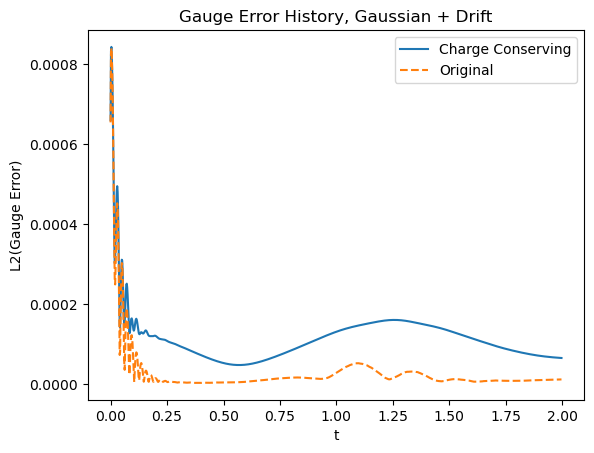

In [ ]:
plt.plot(ts,gauge_error_conserving, label="Charge Conserving")
plt.plot(ts,gauge_error_original, "--", label="Original")
plt.title("Gauge Error History, Gaussian + Drift")
plt.legend()
# plt.ylim([0,.000001])
plt.xlabel("t")
plt.ylabel("L2(Gauge Error)")

Text(0, 0.5, 'L2(Gauge Error)')

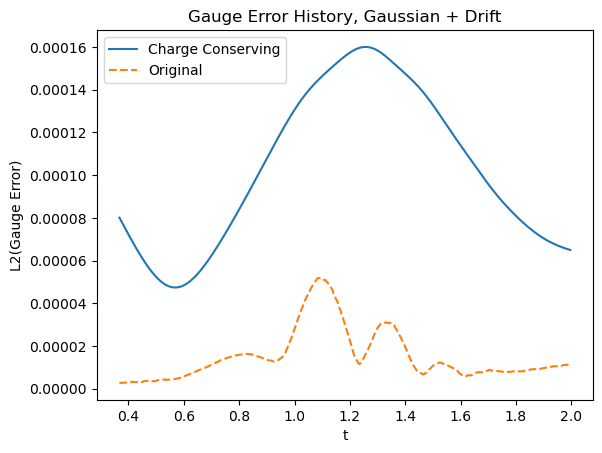

In [ ]:
a = 200
plt.plot(ts[a:],gauge_error_conserving[a:], label="Charge Conserving")
plt.plot(ts[a:],gauge_error_original[a:], "--", label="Original")
plt.title("Gauge Error History, Gaussian + Drift")
plt.legend()
# plt.ylim([0,.000001])
plt.xlabel("t")
plt.ylabel("L2(Gauge Error)")

Text(0, 0.5, 'L2(Gauge Error)')

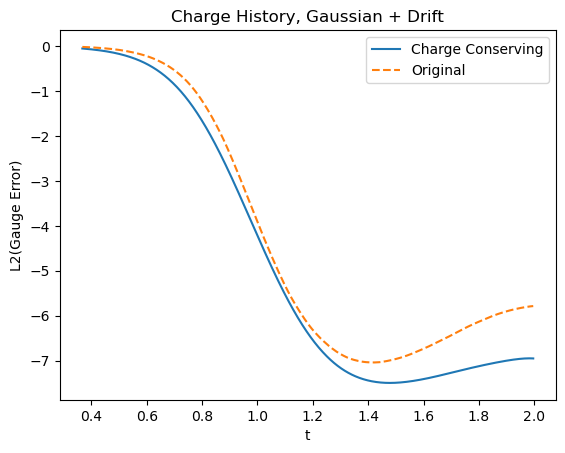

In [ ]:
a = 200
plt.plot(ts[a:],rho_history_conserving[a:], label="Charge Conserving")
plt.plot(ts[a:],rho_history_original[a:], "--", label="Original")
plt.title("Charge History, Gaussian + Drift")
plt.legend()
# plt.ylim([0,.000001])
plt.xlabel("t")
plt.ylabel("L2(Gauge Error)")

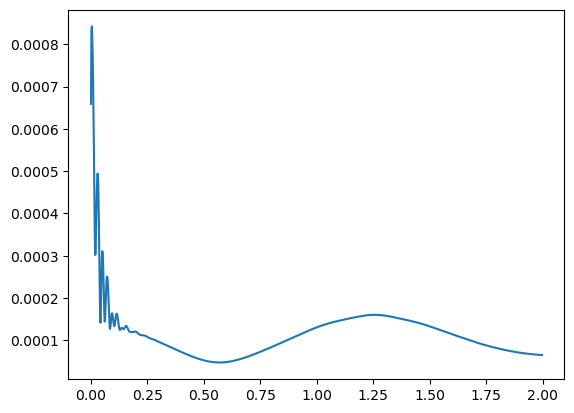

In [ ]:
plt.plot(ts,gauge_error_conserving, label="Charge Conserving")

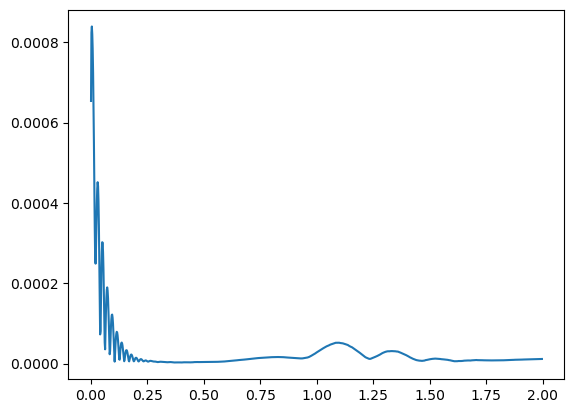

In [ ]:
plt.plot(ts,gauge_error_original, label="Charge Conserving")

Text(0, 0.5, 'Electron Velocity Variance')

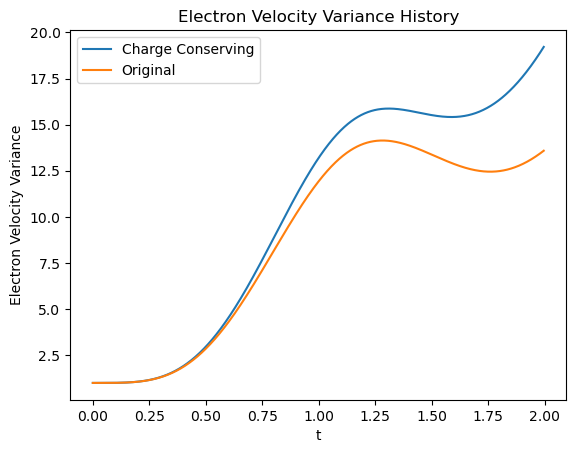

In [ ]:
plt.plot(ts,v_elec_var_history_conserving, label="Charge Conserving")
plt.plot(ts,v_elec_var_history_original, label="Original")
plt.title("Electron Velocity Variance History")
plt.legend()
plt.xlabel("t")
plt.ylabel("Electron Velocity Variance")